# Section IV - MNIST


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, manifold
from sklearn.utils import shuffle


import helpers as HL
import plot_functions as PL
import pickle_functions as PK

%load_ext autoreload
%autoreload 2

#constants
folder="mnist_pickles"
nb_samples = 1000
grid_width = 24

** \\\\\\\\\\\\\\  TODO  \\\\\\\\\\\\\\**
- fill thing from report

-----
-----
## A. The dataset

### Description
- "Copy paste"-ish or summarize from report



In [2]:
# Loading dataset
inputs, targets = HL.import_mnist()

# some constanst
n_samples, n_features = inputs.shape
n_neighbors = 30
pixel_width = int(np.sqrt(inputs.shape[1]))
print("pixel_width of each image: ", pixel_width)
print("range of grayscale pixel values: [{},{}]".format(inputs.min(), inputs.max()))


inputs shape:  (70000, 784)
targets shape:  (70000,)
pixel_width of each image:  28
range of grayscale pixel values: [0,255]


### Insight in the dataset

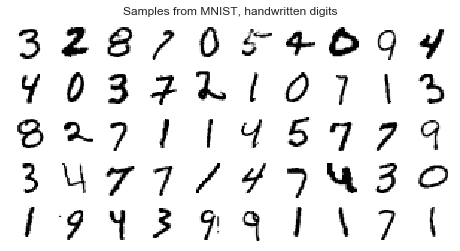

In [3]:
PL.plot_digits_samples(inputs, row_dim=5, col_dim=10)

As you can see this is the dataset input is a picture with 8x8 pixels. low resolution

Next we will look as some local variation in the data within the same classes/digits

In [ ]:
# show differences in 7's
X_7 = HL.get_X_with_label(inputs, targets, 7)
plt.imshow(np.hstack((X_7[1].reshape((pixel_width,pixel_width)), X_7[2].reshape((pixel_width,pixel_width)))), cmap=plt.cm.binary)
plt.show()
# show differences in 1's
X_1 = HL.get_X_with_label(inputs, targets, 1)
plt.imshow(np.hstack((X_1[1].reshape((pixel_width,pixel_width)), X_1[316].reshape((pixel_width,pixel_width)))), cmap=plt.cm.binary)
plt.show()

Here we can see some of the variations one could expect from handwritten digits. There are different types of writing. The seven can be written with or without a crossbar at the top image. Some ones are written with a bottom crossbar like the one to right some are not. These are just one of the variations we can occur in the 

------
------
## B. LLE

- describe our use of accuracy and why we are plotting and looking at/for
- then we eill look at some of the interesting parameter values to look at their effect on embedding
- then show the optimized example
----
### Accuracy analysis of hyperparameters

In [4]:
test_lle_dict = PK.kmeans_clustering_f1_measure(inputs, targets, "lle", grid_width=grid_width, nb_samples=nb_samples,
                                         reg_range=(-8, 8), neighbor_range=(3,26), plot=True, create=False)

FileNotFoundError: [Errno 2] No such file or directory: 'mnist_pickles/F1_lle_grid-24_samples-1000_normal.pkl'

In [ ]:
lle_dict = PK.kmeans_clustering_accuracy(inputs, targets, "lle", grid_width=grid_width, nb_samples=nb_samples,
                                         reg_range=(-8, 8), neighbor_range=(3,26), plot=True, create=False)

### Discussion of heatmap
- 
- sensitivity to nb_neighbors/reg
- high reg safer
- pretty low nb_neighbors compared to Toy dataset
- so noisy it is hard 


-----
### LLE-embedding with interesting hyperparameters
given the accuracy analysis of the hyperparameters we want to take a closer look on what their effect is in a couple of different embeddings.

In [ ]:
for i in np.logspace(-8, 8, 24, endpoint=True):
    print(i)

In [ ]:
nb_components = 2
# parameters of interest
nb_neighbors = (5,19)
regs = (2.46209240149e-07, 1350.31403787)

X_lle_1 = manifold.LocallyLinearEmbedding(nb_neighbors[0], nb_components, reg=regs[0], method='standard') \
                  .fit_transform(inputs[0:nb_samples])
X_lle_2 = manifold.LocallyLinearEmbedding(nb_neighbors[0], nb_components, reg=regs[1], method='standard') \
                  .fit_transform(inputs[0:nb_samples])
X_lle_3 = manifold.LocallyLinearEmbedding(nb_neighbors[1], nb_components, reg=regs[0], method='standard') \
                  .fit_transform(inputs[0:nb_samples])
X_lle_4 = manifold.LocallyLinearEmbedding(nb_neighbors[1], nb_components, reg=regs[1], method='standard') \
                  .fit_transform(inputs[0:nb_samples])


In [ ]:
#parameters:
im = True # whether or not to show images
t = 9e-3 # how close the images should be shown

fig = plt.figure(figsize=(15,15))
l_ax1 = PL.plot_embedding(inputs, X_lle_1, targets[0:nb_samples], fig=fig, subplot_pos=221, images=im, im_thres=t, title="A: Number of neighbors: "+str(nb_neighbors[0])+", Regularization: "+str(regs[0]))
l_ax2 = PL.plot_embedding(inputs, X_lle_2, targets[0:nb_samples], fig=fig, subplot_pos=222, images=im, im_thres=t, title="B: Number of neighbors: "+str(nb_neighbors[0])+", Regularization: "+str(regs[1]))
l_ax3 = PL.plot_embedding(inputs, X_lle_3, targets[0:nb_samples], fig=fig, subplot_pos=223, images=im, im_thres=t, title="C: Number of neighbors: "+str(nb_neighbors[1])+", Regularization: "+str(regs[0]))
l_ax4 = PL.plot_embedding(inputs, X_lle_4, targets[0:nb_samples], fig=fig, subplot_pos=224, images=im, im_thres=t, title="D: Number of neighbors: "+str(nb_neighbors[1])+", Regularization: "+str(regs[1]))
plt.savefig("images/MNIST_lle_embeddings")
plt.show()


### Discussion of embeddings
hyperparameters effect:
- high reg forces triangle structure
- high nb_neighbors MIGHT make crowding problem more probable
- high nb_neighbors gives less structured(triangle) embedding
- maybe make plotnumbers(Plot 1,2,3,4) so its easier to talk about them
- high nb_neigh and low reg gives bad results in accuracy and the embedding only focus on showing the variance og 

overall LLE:
- looks like LLE emdeds rotation pretty well(see 1's and also plot1 with clockwise rotation of 7,7,4,2,9), but has a lot of problem with the more complicated structures like 3,5,6,8
- has a very defined structure that comes from....????? refer to equation/theory.

### LLE embedding with optimized hyperparameters
When finding the optimal hyperparameters for this embedding. The previous analysises are useful. Ruling out hyperparameters that scores very badly in the accuracy score and insight in the different hyperparameters effect guides us to our thought to be optimal embedding.
Criterions for choosing a "good" embedding:
- as little overlapping of same classes
- local neighbors are similar if not the same class
- some "global" structure that emerges that is fairly continous (ex: thickness, rotation, )

In [ ]:
# best so far (n = 5, reg = 0.0182334800087) (n=9, reg = 0.0904735724235)
#parameters:
t = 3e-3 # how close the images should be shown
nb_components = 2

n = 5
reg = 0.0182334800087
fig = plt.figure(figsize=(15,7))
best_lle = manifold.LocallyLinearEmbedding(n, nb_components, reg, method='standard') \
                  .fit_transform(inputs[0:nb_samples])

best_lle_ax_1 = PL.plot_embedding(inputs, best_lle, targets[0:nb_samples], fig=fig, subplot_pos=121, images=False, im_thres=t, title="A: Number og neighbors: "+str(n)+", Regularization: "+str(reg))
best_lle_ax_2 = PL.plot_embedding(inputs, best_lle, targets[0:nb_samples], fig=fig, subplot_pos=122, images=True, im_thres=t, title="A: Number og neighbors: "+str(n)+", Regularization: "+str(reg))
plt.savefig("images/MNIST_opt_lle_embedding")
plt.show()

### Discussion of LLE's optimal embedding
pros cons by lle with tuned hyperparameters

-----
-----

## C. t-SNE
- Explain what we are seeing in the heatmap plot, talk about observation and robustness
- show embedding of interresting parameters
- show best

----
### Accuracy analysis of hyperparameters
- heatmap with perplexity and min_grad_norm with accuracy in each point


In [ ]:
tsne_dict = PK.kmeans_clustering_f1_measure(inputs, targets, "tsne", grid_width=grid_width, nb_samples=nb_samples,
                                          min_grad_norm_range=(-8,0), perplexity_range=(2,100), plot=True, create=False)

In [ ]:
tsne_dict = PK.kmeans_clustering_accuracy(inputs, targets, "tsne", grid_width=grid_width, nb_samples=nb_samples,
                                          min_grad_norm_range=(-8,0), perplexity_range=(2,100), plot=True, create=False)


In [ ]:
for i in np.logspace(-8, 0, 24, endpoint=True):
    print(i)

### Discussion of heatmap
- blabla

-----
### LLE-embedding with interesting hyperparameters
given the accuracy analysis of the hyperparameters we want to take a closer look on what their effect is in a couple of different embeddings.

In [ ]:
# parameters of interest
perplexity = (6,82)
min_grad_norm = (4.961947603e-08, 0.0406158598838) # then test 0.448925125822 then 100

X_tsne_1 = manifold.TSNE(n_components=2, perplexity=perplexity[0], min_grad_norm=min_grad_norm[0], init='random', random_state=123) \
                   .fit_transform(inputs[0:nb_samples])
X_tsne_2 = manifold.TSNE(n_components=2, perplexity=perplexity[0], min_grad_norm=min_grad_norm[1], init='random', random_state=123) \
                   .fit_transform(inputs[0:nb_samples])
X_tsne_3 = manifold.TSNE(n_components=2, perplexity=perplexity[1], min_grad_norm=min_grad_norm[0], init='random', random_state=123) \
                   .fit_transform(inputs[0:nb_samples])
X_tsne_4 = manifold.TSNE(n_components=2, perplexity=perplexity[1], min_grad_norm=min_grad_norm[1], init='random', random_state=123) \
                   .fit_transform(inputs[0:nb_samples])


In [ ]:
# parameters
im = True # whether or not to show images
t = 9e-3 # how close the images should be shown

fig = plt.figure(figsize=(15,15))
t_ax1 = PL.plot_embedding(inputs, X_tsne_1, targets[0:nb_samples], fig=fig, subplot_pos=221, images=im, im_thres=t, title="A: Perplexity: "+str(perplexity[0])+", Min_grad_norm: "+str(min_grad_norm[0]))
t_ax2 = PL.plot_embedding(inputs, X_tsne_2, targets[0:nb_samples], fig=fig, subplot_pos=222, images=im, im_thres=t, title="B: Perplexity: "+str(perplexity[0])+", Min_grad_norm: "+str(min_grad_norm[1]))
t_ax3 = PL.plot_embedding(inputs, X_tsne_3, targets[0:nb_samples], fig=fig, subplot_pos=223, images=im, im_thres=t, title="C: Perplexity: "+str(perplexity[1])+", Min_grad_norm: "+str(min_grad_norm[0]))
t_ax4 = PL.plot_embedding(inputs, X_tsne_4, targets[0:nb_samples], fig=fig, subplot_pos=224, images=im, im_thres=t, title="D: Perplexity: "+str(perplexity[1])+", Min_grad_norm: "+str(min_grad_norm[1]))
plt.savefig("images/MNIST_tsne_embeddings")
plt.show()

### Discussion of embeddings
- sensitivity to nb_neighbors/reg
- high reg safer
- pretty low nb_neighbors compared to Toy dataset
- so noisy it is hard 


### t-SNE embedding with optimized hyperparameters
When finding the optimal hyperparameters for this embedding. The previous analysises are useful. Ruling out hyperparameters that scores very badly in the accuracy score and insight in the different hyperparameters effect guides us to our thought to be optimal embedding.
Criterions for choosing a "good" embedding:
- as little overlapping of same classes
- local neighbors are similar if not the same class
- some "global" structure that emerges that is fairly continous (ex: thickness, rotation, )

In [ ]:
# best so far (n = 5, reg = 0.0182334800087) (n=9, reg = 0.0904735724235)
#parameters:
t = 3e-3 # how close the images should be shown
nb_components = 2

perp = 6
min_grad_norm = 0.000740568469226
fig = plt.figure(figsize=(15,7))
best_tsne = manifold.TSNE(n_components=2, perplexity=perp, min_grad_norm=min_grad_norm, init='random', random_state=123) \
                    .fit_transform(inputs[0:nb_samples])

best_lle_ax_1 = PL.plot_embedding(inputs, best_tsne, targets[0:nb_samples], fig=fig, subplot_pos=121, images=False, im_thres=t, title="A: Number og neighbors: "+str(n)+", Regularization: "+str(reg))
best_lle_ax_2 = PL.plot_embedding(inputs, best_tsne, targets[0:nb_samples], fig=fig, subplot_pos=122, images=True, im_thres=t, title="A: Number og neighbors: "+str(n)+", Regularization: "+str(reg))
plt.savefig("images/MNIST_opt_tsne_embedding")
plt.show()

### Discussion of LLE's optimal embedding
pros cons by lle with tuned hyperparameters

-----------------------
### Summary of process and metrics
- discuss accuracy as metric and how we weighted that in the decision of choosing best plots

## D. Comparison of LLE vs t-SNE
- show the two best examples
- discuss pros and cons in
    - data/cases it handles well or not with observation on this dataset
    - robustness to parameters in different cases
    - potensial
    - should we do computational analysis here?